# Boundary Relation Tests

## Setup

### Imports

In [1]:
from math import sqrt, pi

# Shared Packages
import pandas as pd
import numpy as np

# Local functions and classes
from types_and_classes import *
from utilities import *
from debug_tools import *
from structure_slice import *
from structure_set import *
from relations import *
#from metrics import *


### Global Settings

In [2]:
PRECISION = 2

In [3]:
%matplotlib inline

## Adjusting Boundary Slice Relations

For the beginning and ending slices of a structure the entire contour must
be treated as a boundary.  The structure does not have an interior on these
slices. In this case the “*Interior*” relations become “*Boundary*” relations.

The “*Interior*” bits of the DE-9IM relationship metric are combined with the 
“*Boundary*” bits using "OR" logic.  This will keep the “*Boundary*” bits as 
part of the boundary.


### Identify Boundaries

- Nodes are shapley.Polygons and contain attributes:
    - polygon: shapley.Polygon
    - roi: SliceNeighbours
    - slices: SliceIndexType
    - is_hole: bool = False
    - is_interpolated: bool = False
    - is_empty: bool = True

- Edges are the match between regions:
    - Edges only connect nodes that are on adjacent slices.
    - Edges only connect nodes that are part of the same ROI.
    - Regions that are holes only connect to other holes.
    - Regions that are not holes only connect to other regions that are not holes.
    - The edge has a weight that is the difference between slice values 
       (The 'Z' distance between the two regions).
    - Edges are found by selecting regions with the same roi, neighbouring
        slice values, matching hole type and intersecting polygons.


### Boundary checks are done by *region* not by *structure*

- For all structures the `StructureSlice.contour` MultiPolygon for each slice 
    is separated into individual polygons and holes (Regions).
- Each region becomes a node in a networkx graph. 
- This allows for the regions to be tracked as they merge and split.
- Overlapping polygons on the next slice are linked by an edge.
- If a regions is not matched to another region, it is considered a 
- “*Boundary*”.  This is identified as nodes with less than 2 edges ($degree < 2$).
  

### Managing holes
- The boundaries of holes must also be checked.

- The `DE9IM` relationship for a hole is different than for a structure.
  - The interior of a hole is the exterior of the structure.
  - The exterior of a hole is undefined. It may or may not be within the
      interior of the structure.
    The Interior relations become Exterior relations for holes.
- When hole boundaries are tested, only the "contour" “*Boundary*” bits of
    the `DE27IM` relationship are used.  The external and hull bits are set to `'FFFFFFFFF'`.


### Secondary Boundaries
- Boundaries in the Secondary ROI also need to be evaluated as well as the Primary ROI.
- The resulting relation is transposed before being combined with the other relation values.


### Boundary Interpolation

- The last slice with a contour is not the actual boundary.  The boundary is
  half way between the last slice with a contour and the fist slice without a 
  contour.  
- The last slice is interpolated to create the boundary.
- The boundary slice index is half way between the two indexes (The mean).


#### Interpolation process
- Takes two polygons or one polygon and a "vanishing point" (The centroid of the polygon).
- Takes two SliceIndex values and calculates the mean as the new SliceIndex.

1.  For each coordinate point on the first polygon build a line from it to the
    closest point on the second polygon.
2. Return the half way point of this line as the new coordinate point.
4. The Z value of the new point is the mean of the Z values of the two slices.
3. Build a new polygon from the set of all the new coordinate points.


#### interpolated boundary slices
- The `interpolate_polygon` function takes a pair of slice indexes and one or two polygons.
- For boundary slices the second polygon is the centroid of the first polygon.
- The second slice index is the index of the slice without an edge.
    - This is identified by getting the two slice indexes from slice_neighbours selecting the one that is not adjacent to the node.
- The interpolated boundary slices are added to the graph as nodes and linked to the original boundary slice nodes.

### Boundary Slice Relations
- Each interpolated boundary slice is tested against every region in the other structure for boundary relations.

1. For each interpolated boundary slice in the first roi:
    1. select all regions in the other roi with slice indexes between the previous and next slice_neighbours values as a collection of sub-graphs.
    2. For each sub-graph:
        1. if the sub-graph has a node with the same slice index as the the interpolated boundary, get the relation for the polygons in those two nodes.
        2. Otherwise, generate an interpolated polygon using the nodes with the two closest slice indexes and get the relation for the polygons in those two nodes.
2. Repeat the process for the interpolated boundary slice in the second roi.

*Question*
- Slice 0.4 is a boundary for #5, and is a neighbour to the boundary for #1.
- Will it get the relation wrong if I test it as a boundary for both #1 and #5?
> Probably not, because regular relations are also tested  for slice 0.4.  
> For 0.4, #5 will be external to #1.

Matched boundary slices are those that are boundary slices of both structures. 

The boundary slices are selected based on the following conditions:
1. The 
slice is at a boundary of the primary structure.
2. The slice has both a primary and secondary contour.
3. **The one of the neighbouring slices has neither primary nor secondary contour.**

\# 3 is the problem. The neighbouring slice should have a contour of the other structure.
    
Offset boundary slices are those where the boundary of the primary structure 
is a neighbour of the boundary of the secondary structure
    
The boundary slices are selected on the following basis:
1. The slice is at a boundary of the primary structure.
2. The slice does not have the secondary structure.
3. The one of the neighbouring slices has only the second structure.

- If the hole and the other polygon do not overlap then exterior does not become interior.
- The interior of the hole becomes the exterior.
- The exterior of the hole is undefined and ignored. (other regions deal with that)

![alt text](Images/DE-9IM.png)

![alt text](../reference/RelationshipTreeDiagram.svg)

## Test structures


In [4]:
def simple_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1,
                                  offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder within primary
    contained_cylinder = make_vertical_cylinder(roi_num=2, radius=3, length=0.5,
                                             offset_x=0, offset_z=-0.2,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, contained_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [5]:
slice_table = simple_cylinders()
regions = generate_region_graph(slice_table)
selected_roi = [1, 2]
relation = find_relations(slice_table, regions, selected_roi)
print(relation.identify_relation())

Relationship: Contains


In [6]:
def parallel_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    left_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    right_middle_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)
    left_boundary_cylinder1 = make_vertical_cylinder(roi_num=3, radius=1, length=0.2,
                                             offset_x=-2.5, offset_z=-0.4,
                                             spacing=slice_spacing)
    left_boundary_cylinder2 = make_vertical_cylinder(roi_num=3, radius=1, length=0.2,
                                             offset_x=-2.5, offset_z=0.3,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, left_cylinder, right_cylinder,
                            right_middle_cylinder,
                            left_boundary_cylinder1,left_boundary_cylinder2])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [7]:
slice_table = parallel_cylinders()
regions = generate_region_graph(slice_table)
selected_roi = [1, 2]
relation = find_relations(slice_table, regions, selected_roi)
print(relation.identify_relation())

Relationship: Partition


In [8]:
slice_table = parallel_cylinders()
regions = generate_region_graph(slice_table)
selected_roi = [1, 3]
relation = find_relations(slice_table, regions, selected_roi)
print(relation.identify_relation())

Relationship: Borders


In [9]:
def embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    primary_cylinder = make_vertical_cylinder(roi_num=9, radius=6, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    center_hole = make_vertical_cylinder(roi_num=9, radius=4, length=0.5,
                                         offset_z=-0.2, spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    confines_cylinder = make_vertical_cylinder(roi_num=10, radius=3, length=0.5,
                                             offset_z=-0.2,
                                             spacing=slice_spacing)
    surrounds_cylinder = make_vertical_cylinder(roi_num=11, radius=2, length=0.3,
                                         offset_z=-0.1, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, center_hole,
                            confines_cylinder, surrounds_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(embedded_cylinder(), [9, 10]))


In [10]:
slice_table = embedded_cylinder()
regions = generate_region_graph(slice_table)
selected_roi = [9, 10]
relation = find_relations(slice_table, regions, selected_roi)
print(relation.identify_relation())

Relationship: Confines


#### Concentric cylinders starting on the same slice
  
<img src="Images\Boundaries\PartitionSup3D.png" alt="PartitionSup3D" style="height:50px;">
<img src="Images\Boundaries\PartitionSup2D.png" alt="PartitionSup2D" style="height:30px;">

In [11]:
def concentric_cylinders_same_start():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders starting on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    sup_partition = make_vertical_cylinder(roi_num=2, radius=1, length=0.4,
                                           offset_z=-0.3,
                                           spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, sup_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [12]:
slice_table = concentric_cylinders_same_start()
regions = generate_region_graph(slice_table)
selected_roi = [1, 2]
relation = find_relations(slice_table, regions, selected_roi)
print(relation.identify_relation())

Relationship: Contains


In [13]:
def dual_embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.5, offset_z=-0.8,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.9,
                                              offset_z=-0.5,
                                              spacing=slice_spacing)
    left_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                       offset_x=-2.5, offset_z=-0.4,
                                       spacing=slice_spacing)
    right_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                       offset_x=2.5, offset_z=-0.4,
                                       spacing=slice_spacing)
    # cylinder with interior borders
    confines_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.7,
                                             offset_x=2.5, offset_z=-0.4,
                                             spacing=slice_spacing)

    # cylinder completely inside of a hole
    surrounds_cylinder = make_vertical_cylinder(roi_num=3, radius=1, length=0.3,
                                             offset_x=-2.5, offset_z=-0.2,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder1 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=-0.7,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder2 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=0.4,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, left_hole, right_hole,
                            confines_cylinder, surrounds_cylinder,
                            bordering_cylinder1, bordering_cylinder2])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [14]:
slice_table = dual_embedded_cylinder()
regions = generate_region_graph(slice_table)
selected_roi = [1, 2]
relation = find_relations(slice_table, regions, selected_roi)
print(relation.identify_relation())

Relationship: Confines


# Error: Subgraph must contain only two nodes.

In [15]:
selected_roi = [1, 3]
relation = find_relations(slice_table, regions, selected_roi)
print(relation.identify_relation())

Relationship: Surrounds


In [16]:
selected_roi = [1, 4]
relation = find_relations(slice_table, regions, selected_roi)
print(relation.identify_relation())

Relationship: Borders


#### Embedded boxes

![ContainsCubes](ContainsCubes.png)

In [17]:
def embedded_boxes():
    slice_spacing = 0.5
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=20, length=30, offset_z=-15,
                                spacing=slice_spacing)
    # embedded boxes
    cube6 = make_box(roi_num=1, width=6, spacing=slice_spacing)
    cube3 = make_box(roi_num=2, width=3, offset_z=0, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([cube6, cube3, body])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table

In [18]:
slice_table = embedded_boxes()
selected_roi = [1, 2]
relation = find_relations(slice_table, regions, selected_roi)
print(relation.identify_relation())

Relationship: Partition


#### Bordering Cylinders
- Identify the boundary slices of the Primary and the neighbouring slice(s) that do not have a primary.
- For each of these neighbouring slices, if the slice has a Secondary contour, select that Secondary slice.

![Bordering cylinders](FreeCAD_Scripts/BorderingCylinders.png)

In [18]:
def bordering_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder1 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=-0.5,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder2 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=0.4,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, bordering_cylinder1,
                            bordering_cylinder2])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [ ]:
slice_table = bordering_cylinders()
selected_roi = [1, 4]

relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

#### Partition Cylinders
- Identify the boundary slices of the Primary and the neighbouring slice(s) that do not have a primary.
- For each of these neighbouring slices, if the slice does not have a Secondary contour, but there is a Secondary contour on the same slice as the Primary boundary, select that Secondary slice.


In [20]:
def partitions_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder with interior borders
    partitioning_cylinder = make_vertical_cylinder(roi_num=3, radius=3, length=0.7,
                                             offset_x=0, offset_z=-0.3,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, partitioning_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [ ]:
slice_table = partitions_cylinder()
selected_roi = [1, 3]

relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

# Done To Here

In [22]:
def overlapping_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder with interior borders
    overlapping_cylinder = make_vertical_cylinder(roi_num=5, radius=3, length=0.9,
                                             offset_x=0, offset_z=-0.3,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, overlapping_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


In [ ]:
slice_table = overlapping_cylinder()
selected_roi = [1, 5]

relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

In [24]:
def cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1,
                                  offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    # cylinder within primary
    contained_cylinder = make_vertical_cylinder(roi_num=2, radius=3, length=0.5,
                                             offset_x=0, offset_z=-0.2,
                                             spacing=slice_spacing)
    # cylinder with matching borders
    partitioning_cylinder = make_vertical_cylinder(roi_num=3, radius=3, length=0.7,
                                             offset_x=0, offset_z=-0.3,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder1 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=-0.5,
                                             spacing=slice_spacing)
    # cylinder bordering primary cylinder
    bordering_cylinder2 = make_vertical_cylinder(roi_num=4, radius=3, length=0.2,
                                             offset_x=0, offset_z=0.4,
                                             spacing=slice_spacing)
    # cylinder overlapping positive
    overlapping_cylinder = make_vertical_cylinder(roi_num=5, radius=3, length=0.8,
                                             offset_x=0, offset_z=-0.3,
                                             spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, contained_cylinder,
                            partitioning_cylinder,
                            bordering_cylinder1, bordering_cylinder2,
                            overlapping_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


# Error Should be contains

In [ ]:
slice_table = cylinders()
selected_roi = [1, 2]

#relation = find_relations(slice_table, selected_roi)
#print(relation.identify_relation())

In [ ]:
slice_table = cylinders()
# Split each Structure into distinct regions for boundary tests.
region_table = make_region_table(slice_table)
# Identify the boundary slices of each region.
region_boundaries = find_boundary_slices(region_table)
# For each slice of each region identify the whether the region is present on
# the neighbouring slice.
neighbour_match = identify_neighbour_slices(region_table)
# Slice range = Min(starting slice) to Max(ending slice)
selected_slices = select_slices(slice_table, selected_roi)
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = list(selected_slices.agg(relate_structures,
                                            structures=selected_roi,
                                            axis='columns'))
relation =  merged_relations(mid_relations)
print(relation.identify_relation())

In [27]:
boundary_relations = get_boundary_relations(region_table, neighbour_match, region_boundaries, selected_roi)

In [ ]:
for key, value in boundary_relations.items():
    print(key)
    print(value.identify_relation())
    print(value)


In [ ]:
a = region_table.at[-0.3, (1, 'b')].polygon
b = np.NaN
plot_ab(a, shapely.Polygon())
print(DE27IM(a, b).identify_relation())
print(DE9IM(a, shapely.Polygon()))


In [ ]:
a = region_table.at[-0.2, (2, 'c')].polygon
b = region_table.at[-0.2, (1, 'b')].polygon
plot_ab(a, b)
print(DE27IM(a, b).identify_relation())
print(DE9IM(a, b))


((2, 'c'), (1, 'b'), (-0.2, -0.3))
Relationship: Borders
|000|	|000|	|000|
|011|	|000|	|000|
|001|	|000|	|000|

# Logic Error: interpolated slice `(-0.2, -0.3)` is considered a boundary for both structures.  It should be a boundary for `(2, 'c')` only.
- build the interpolated region as the region_table is being constructed.
- This will also be useful for calculating volumes.
- `mid_relations` will need to drop the interpolated slices.
- `identify_neighbour_slices` will not be required.

In [ ]:
set_adjustments(region_table, region_boundaries, selected_roi,
                (2, 'c'), (1, 'b'), [-0.2, -0.3])

In [ ]:
~region_table[[(1, 'b'), (2, 'c')]].isna()

In [ ]:
slice_table = cylinders()
selected_roi = [1, 2]

relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

In [ ]:
slice_table = cylinders()
selected_roi = [1, 5]

relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

In [ ]:
slice_table = cylinders()
selected_roi = [1, 5]

relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

In [ ]:
slice_table = cylinders()
selected_roi = [1, 5]

relation = find_relations(slice_table, selected_roi)
print(relation.identify_relation())

In [27]:
slice_table = cylinders()
region_table = make_region_table(slice_table)


In [28]:
selected_roi = [1, 5]


In [29]:
holes = region_table.map(is_hole).apply(any)
structure_regions = region_table.loc[:,~holes][selected_roi]
structure_boundaries = find_boundary_slices(structure_regions)


In [30]:
poly_a, poly_b = selected_roi


- For each boundary slice of the Primary ROI identify the neighbouring slice(s) that do not have a primary.


In [31]:
# Slices that have both primary and secondary structures.
s_p = slice_table.map(empty_structure, invert=True)[selected_roi]
s_p = s_p.apply(all, axis='columns')

# slices that have the secondary structure but not the primary structure.
s_not_p = slice_table.map(empty_structure)[selected_roi].copy()
s_not_p[poly_b] = ~s_not_p[poly_b]
s_not_p = s_not_p.apply(all, axis='columns')

# slices that are boundaries of the primary structure.
primary_b = structure_boundaries[poly_a].copy()


In [32]:
def match_slice(primary_b: pd.Series, sp: pd.Series, selected_roi, shift_dir: int):
    poly_a, poly_b = selected_roi
    n1 = sp & primary_b.shift(shift_dir)
    b1 = n1.index.to_series().shift(shift_dir)[n1]
    b1.name=poly_a
    b1 = b1.reset_index()
    b1.columns = [poly_b, poly_a]
    return b1


- If the neighbouring slice has a Secondary contour, select that Secondary slice.
	

In [ ]:

bp = match_slice(primary_b, s_not_p, selected_roi, 1)
bn = match_slice(primary_b, s_not_p, selected_roi, -1)


- If the slice does not have a Secondary contour, but there is a Secondary contour on the same slice as the Primary boundary, select that Secondary slice.

In [22]:
b0 = match_slice(primary_b, s_p, selected_roi, 0)


In [ ]:
bn

In [ ]:
selected_roi = [1, 5]
a = slice_table.map(empty_structure, invert=True)[selected_roi]
a.columns = [f'HasContour({roi})' for roi in selected_roi]
b = structure_boundaries[selected_roi]
b.columns = [f'IsBoundary({roi})' for roi in selected_roi]
pd.concat([a, b], axis='columns')

In [ ]:
# Slice range = Min(starting slice) to Max(ending slice)
selected_slices = select_slices(slice_table, selected_roi)
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = selected_slices.agg(relate_structures,
                                    structures=selected_roi,
                                    axis='columns')
mid_relations.name = 'DE27IM'
print(mid_relations[0.4])

In [96]:
# Slice range = Min(starting slice) to Max(ending slice)
selected_slices = select_slices(slice_table, selected_roi)
# Send all slices with both Primary and Secondary contours for standard
# relation testing
mid_relations = selected_slices.agg(relate_structures,
                                    structures=selected_roi,
                                    axis='columns')
mid_relations.name = 'DE27IM'
#mid_relations

#### Confines Cylinders
- Identify the boundary slices of the Primary and the neighbouring slice(s) that do not have a primary.
- For each of these neighbouring slices, if the slice does not have a Secondary contour, but there is a Secondary contour on the same slice as the Primary boundary, select that Secondary slice.

  
![Confines cylinder](FreeCAD_Scripts/confines_cylinder.png)



5. Match hole boundary slices for boundary tests:
   - For each hole boundary slice of the Primary ROI, if the slice has a Secondary contour, select that contour for comparison.
   - If the slice does not have a Secondary contour, identify the neighbouring slice that also has a hole.
   - If the neighbouring slice has a Secondary contour, select that contour.
   - If the neighbouring slice does not have a Secondary contour, boundary testing is not required.


  

In [1]:
def confines_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1.1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Centred cylinder with two embedded cylinders
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    left_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # cylinder with interior borders
    confines_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, left_hole, right_hole,
                            confines_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#### Concentric cylinders ending on the same slice.

<img src="Images\Boundaries\PartitionInf3D.png" alt="PartitionInf3D" style="height:50px;">
<img src="Images\Boundaries\PartitionInf2D.png" alt="PartitionInf2D" style="height:30px;">

In [26]:
def concentric_cylinders_same_end():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders ending on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    inf_partition = make_vertical_cylinder(roi_num=3, radius=1, length=0.4,
                                           offset_z=0, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, inf_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(concentric_cylinders_same_end(), [1, 3]))


- Concentric cylinders starting and ending on the same slice.

<img src="Images\Boundaries\Partition3D.png" alt="PartitionInf3D" style="height:50px;">
<img src="Images\Boundaries\Partition2D.png" alt="PartitionInf2D" style="height:30px;">

In [27]:
def concentric_cylinders_same_height():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Concentric cylinders starting and ending on the same slice
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=2, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    mid_partition = make_vertical_cylinder(roi_num=4, radius=1, length=0.7,
                                           offset_z=-0.3,
                                           spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, mid_partition])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(concentric_cylinders_same_height(), [1, 4]))


### Exterior Borders
  - Primary: Central Cylinder
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF cylinders in one structure with single slice gap at the SUP/INF boundary of the central cylinder.

      
![Exterior Border SUP](Images/Boundaries/ExteriorBorders2D_SUP.png)
![Exterior Border INF](Images/Boundaries/ExteriorBorders2D_INF.png)

In [28]:
def stacked_cylinders():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    outside_cylinder = make_vertical_cylinder(roi_num=5, radius=2, length=0.4,
                                              offset_z=-0.4,
                                              spacing=slice_spacing)
    inside_cylinder = make_vertical_cylinder(roi_num=6, radius=1, length=0.4,
                                             offset_z=0, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, outside_cylinder, inside_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(stacked_cylinders(), [5, 6]))


### Interior Borders
  - Primary: Central Cylinder
  - Concentric shorter hole in the center of the primary cylinder
  - Secondary same height as hole but narrower
  - Interior borders at the and bottom of hole.
  
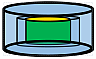
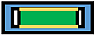

In [29]:
def embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    primary_cylinder = make_vertical_cylinder(roi_num=9, radius=4, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    center_hole = make_vertical_cylinder(roi_num=9, radius=2, length=0.5,
                                         offset_z=-0.2, spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    middle_cylinder = make_vertical_cylinder(roi_num=10, radius=1, length=0.5,
                                             offset_z=-0.2,
                                             spacing=slice_spacing)
    reference = make_vertical_cylinder(roi_num=11, radius=2, length=0.5,
                                         offset_z=-0.2, spacing=slice_spacing)
    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, center_hole, middle_cylinder, reference])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(embedded_cylinder(), [9, 10]))


- The `boundary_match` and `match_neighbour_slices` functions will need to be updated to include the hole boundary tests.
  - For hole boundaries, select the neighboring slice (s) that *DO* have a hole contour.
  - The Secondary slice selection works as usual.

In [30]:
def dual_embedded_cylinder():
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=12, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    primary_cylinder = make_vertical_cylinder(roi_num=1, radius=5, length=0.7,
                                              offset_z=-0.3,
                                              spacing=slice_spacing)
    left_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=-2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    right_hole = make_vertical_cylinder(roi_num=1, radius=2, length=0.5,
                                       offset_x=2.5, offset_z=-0.2,
                                       spacing=slice_spacing)
    # Two concentric cylinders different z offsets
    middle_cylinder = make_vertical_cylinder(roi_num=2, radius=1, length=0.5,
                                             offset_x=2.5, offset_z=-0.2,
                                             spacing=slice_spacing)

    # combine the contours
    slice_data = pd.concat([body, primary_cylinder, left_hole, right_hole, middle_cylinder])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(dual_embedded_cylinder(), [1, 2]))


In [ ]:
def overlapping_cylinders():
    slice_spacing = 0.5
    slice_spacing = 0.1
    # Body structure defines slices in use
    body = make_vertical_cylinder(roi_num=0, radius=10, length=1, offset_z=-0.5,
                                  spacing=slice_spacing)
    # Two overlapping cylinders
    top_cylinder = make_vertical_cylinder(roi_num=7, radius=2, length=0.4, offset_z=-0.3, spacing=slice_spacing)
    bottom_cylinder = make_vertical_cylinder(roi_num=8, radius=2, length=0.4, offset_z=0, spacing=slice_spacing)
   # combine the contours
    slice_data = pd.concat([top_cylinder, bottom_cylinder, body])
    # convert contour slice data into a table of slices and structures
    slice_table = make_slice_table(slice_data, ignore_errors=True)
    return slice_table


#print(find_relationship(overlapping_cylinders(), [7, 8]))


# More Tests Needed

  - Single Primary slice with circular contour.
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF Cylinders in one structure with single slice gap at level of the primary slice. 
- **Partition**
  - Concentric cylinders ending on the same slice.
  - Concentric cylinders starting on the same slice
  - Primary: Central Cylinder
    - Single Secondary slice with circular contour on the SUP/INF slice of the Primary cylinder.
  - Single Primary slice with circular contour
    - Secondary: one of:
      - SUP Cylinder ending on the same slice.
      - INF Cylinder ending on the same slice.
- **CONTAINS**
  - Concentric cylinders with interior cylinder ending inside the exterior cylinder by one slice
**OVERLAPS**
  - Concentric cylinders with interior cylinder ending outside the exterior cylinder by one slice
  - Concentric cylinders with interior cylinder consisting of single slice ending inside the exterior cylinder by one slice


  - Primary: Central Cylinder
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF cylinders in one structure with single slice gap at the SUP/INF boundary of the central cylinder.
  - Single Primary slice with circular contour.
    - Secondary: one of:
      - SUP Cylinder
      - INF Cylinder
      - Combined SUP & INF Cylinders in one structure with single slice gap at level of the primary slice. 
